In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat
torch.set_printoptions(sci_mode=False)

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11, 12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]

In [2]:
version = 'cvt_labels_nuscenes_v4'
cfg1 = get_cfg(DATASET_DIR, version, 'GaussianLSS') # SparseBEVSeg_Det_3 SimpleBEV
device = torch.device('cuda:0') # cuda:5
model_version = '2024_1113_230558'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4
Dataset length: 6019


In [3]:
if CHECKPOINT_PATH is None:
    network.to(device)
    model.to(device)
    model.metrics.reset()
    with_grad = True

    if with_grad:
        network.train()
        # with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            if i != 0:
                continue
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            loss = model.loss_func(pred,batch)
            loss[0].backward()
            vis_result = viz(batch,pred)
            break
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is None:
                print(name)
    else:
        network.eval()
        with torch.no_grad():
            for i,batch in enumerate(loader):
                print(i,end='\r')
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.to(device)
                    elif isinstance(v, list):
                        if isinstance(v[0], torch.Tensor):
                            batch[k] = [i.to(device) for i in v]
                    else:
                        batch[k] = v
                pred = network(batch)
                model.metrics.update(pred,batch)
                # pred['mid_output']['sampled_feats'].retain_grad()
                # loss = model.loss_func(pred,batch)
                # loss[0].backward()
                # vis_result = viz(batch,pred)
                # if i == 25:
                break   
        
    model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


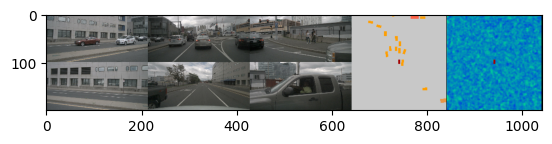

In [4]:
network.to(device)
network.eval()
network.error_tolerance = 1.0
batch = dataset.__getitem__(600)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)[None]
    elif isinstance(v, list):
        if isinstance(v[0], torch.Tensor):
            batch[k] = [i.to(device) for i in v]
    else:
        batch[k] = v
with torch.no_grad():
    pred = network(batch)
    # pred = None
    # loss = model.loss_func(pred,batch)
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

(-0.5, 479.5, 223.5, -0.5)

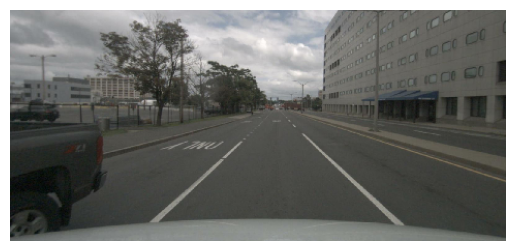

In [ ]:
plt.imshow(batch['image'][0,4].permute(1,2,0).cpu())
plt.axis('off')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 199.5, 79.5, -0.5)

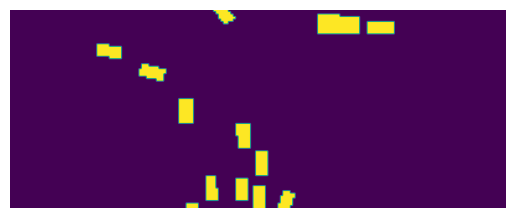

In [ ]:
x = torch.zeros((100,200))
x[::10, :] = 1
x[:, ::10] = 1
vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
# vehicles[:, 0, ::4, ::4] = 1
x = vehicles[0,0].detach().cpu().numpy()[:80]
print(x)
plt.imshow(x)
plt.axis('off')

In [ ]:
from sklearn.decomposition import PCA
render_ = pred['mid_output']['multi_scale_bev'][2]
pca = PCA(n_components=128)
bev_h, bev_w = render_.shape[-2:]
feat = render_[0, :].permute(1,2,0).view(-1, 128).cpu().numpy()
feat = pca.fit_transform(feat).reshape(bev_h,bev_w,128)
plt.imshow(feat[:, :, 0])

KeyError: 'multi_scale_bev'

In [ ]:
n = 6
h = 28
w = 60
# features = rearrange(pred['mid_output']['features'], 'b (n h w) d -> b n h w d', n=n, h=h, w=w)
# mean = rearrange(pred['mid_output']['mean'], 'b (n h w) d -> b n h w d', n=n, h=h, w=w)
# uncertainty = rearrange(pred['mid_output']['uncertainty'], 'b (n h w) -> b n h w', n=n, h=h, w=w)
# direction_vector = rearrange(pred['mid_output']['direction_vector'], 'b (n h w) d -> b n h w d', n=n, h=h, w=w)
# opacities = rearrange(pred['mid_output']['opacities'], 'b (n h w) d -> b n h w d', n=n, h=h, w=w)

features = pred['mid_output']['features']
mean = pred['mid_output']['mean']
uncertainty = pred['mid_output']['uncertainty']
# direction_vector = pred['mid_output']['direction_vector']
opacities = pred['mid_output']['opacities']
# attn = pred['mid_output']['attn']

features = rearrange(features, 'b (n h w) d -> (b n) d h w',n=6, h=h, w=w)
opacities = rearrange(opacities, 'b (n h w) d -> (b n) d h w',n=6, h=h, w=w)
uncertainty = rearrange(uncertainty, 'b (n h w) d -> (b n) h w d',n=6, h=h, w=w)
mean = rearrange(mean, 'b (n h w) d -> (b n) h w d',n=6, h=h, w=w)
# attn = rearrange(attn, 'b m (h w) (hh ww) -> b m h w hh ww', h=h, w=w, hh=h, ww=w)

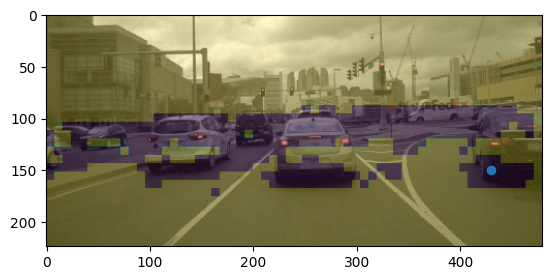

In [ ]:
cam_index = 1
y = 150
x = 430
stage = 0
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
plt.imshow((F.interpolate((opacities<0.05).float(), scale_factor=8)[cam_index, 0]).cpu().numpy(), alpha=0.25)
# plt.imshow((F.interpolate((opacities<0.05).squeeze(2).float(), scale_factor=8)[cam_index,stage]).cpu().numpy(), alpha=0.5)
plt.scatter([x], [y])
# print(depth[0,cam_index,:,y//8,x//8], uncertainty[cam_index, y//8,x//8])

In [ ]:
# stage = 3
# features = pred['mid_output']['gaussians_list'][stage][0].reshape(6, 128, 28, 60)
# mean = pred['mid_output']['gaussians_list'][stage][1].reshape(6, 28, 60, 3)
# uncertainty = pred['mid_output']['gaussians_list'][stage][2].reshape(6, 28, 60, 3, 3)
# uncertainty = uncertainty.flatten(-2,-1)
# uncertainty = torch.cat((uncertainty[..., 0:3], uncertainty[..., 4:6], uncertainty[..., 8:9]), dim=-1)
y1 = y // 8
x1 = x // 8 
y2 = y1 + 1
x2 = x1 + 1
# y1 = 0
# x1 = 0
# y2 = 28
# x2 = 60
print((y2-y1) * (x2-x1))
print('mean:', mean[cam_index, y1, x1])
print("opacity:", opacities[cam_index, :, y1, x1])
print("Uncertainty:", uncertainty[cam_index, y1, x1])
network.gs_render.set_render_scale(int(200), int(200))
render_, _ = network.gs_render.forward_part_gaussians(features, mean, uncertainty, opacities, [1, 6], cam_index, [y1, y2], [x1, x2])
# render_, _ = network.gs_render.forward_part_gaussians(features, mean, uncertainty, opacities, [1, 6], cam_index)

1
mean: tensor([11.4877, -4.6049,  0.2789], device='cuda:0')
opacity: tensor([0.1501, 0.1207, 0.0967], device='cuda:0')
Uncertainty: tensor([ 0.4419, -0.2082, -0.0559,  0.0981,  0.0263,  0.0071], device='cuda:0')


In [ ]:
tmp = []

In [ ]:
tmp.append(render_)

(-0.5, 199.5, 199.5, -0.5)

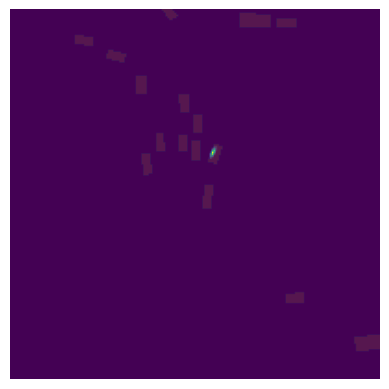

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
bev_h, bev_w = render_.shape[-2:]
feat = render_[0, :].permute(1,2,0).view(-1, 128).cpu().numpy()
feat = pca.fit_transform(feat).reshape(bev_h,bev_w,128)
plt.imshow(feat[:, :, 0])

vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
# vehicles[:, 0, ::4, ::4] = 1
plt.imshow(vehicles[0,0].detach().cpu().numpy(), alpha=0.1)
plt.axis('off')

(-0.5, 149.5, 99.5, -0.5)

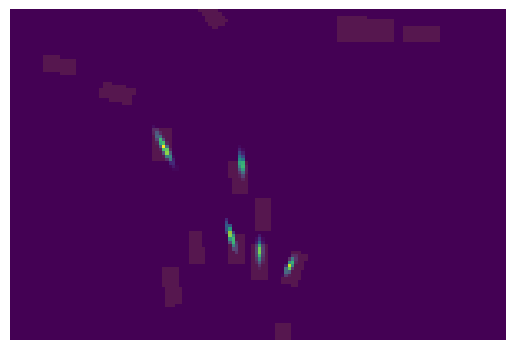

In [ ]:
from sklearn.decomposition import PCA
feats = []
pca = PCA(n_components=128)
for render_ in tmp:
    bev_h, bev_w = render_.shape[-2:]
    feat = render_[0, :].permute(1,2,0).view(-1, 128).cpu().numpy()
    feat = pca.fit_transform(feat).reshape(bev_h,bev_w,128)
    feats.append(feat)

plt.imshow((feats[0]*10 + feats[1]*4 + feats[2]*2 + feats[3] + feats[4]*2)[:100, 25:175, 0])

vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
# vehicles[:, 0, ::4, ::4] = 1
plt.imshow(vehicles[0,0].detach().cpu().numpy()[:100, 25:175], alpha=0.1)
plt.axis('off')

In [ ]:
feats[0]

array([[[-7.1446571e-05,  8.2836709e-07, -2.4187133e-11, ...,
          7.3563792e-17, -9.6941573e-18,  8.6002050e-10],
        [-7.6074626e-05,  3.3511536e-12, -2.2811933e-11, ...,
         -3.2444467e-16, -1.4643389e-16,  1.2493250e-12],
        [-7.6074655e-05, -5.8302647e-12,  1.0038621e-11, ...,
         -5.8644227e-17, -4.7021922e-16,  3.1788482e-12],
        ...,
        [-7.6074655e-05, -5.8568272e-12,  9.7673753e-12, ...,
         -2.2617163e-13,  2.0748576e-12,  3.1919484e-12],
        [-7.6074655e-05, -5.8568272e-12,  9.7673753e-12, ...,
         -2.2617163e-13,  2.0748576e-12,  3.1919484e-12],
        [-7.6074655e-05, -5.8568272e-12,  9.7673753e-12, ...,
         -2.2617163e-13,  2.0748576e-12,  3.1919484e-12]],

       [[-7.6074655e-05, -5.8568272e-12,  9.7673753e-12, ...,
         -2.2617163e-13,  2.0748576e-12,  3.1919484e-12],
        [-7.6074655e-05, -5.8568272e-12,  9.7673753e-12, ...,
         -2.2617163e-13,  2.0748576e-12,  3.1919484e-12],
        [-7.6074655e-05, 

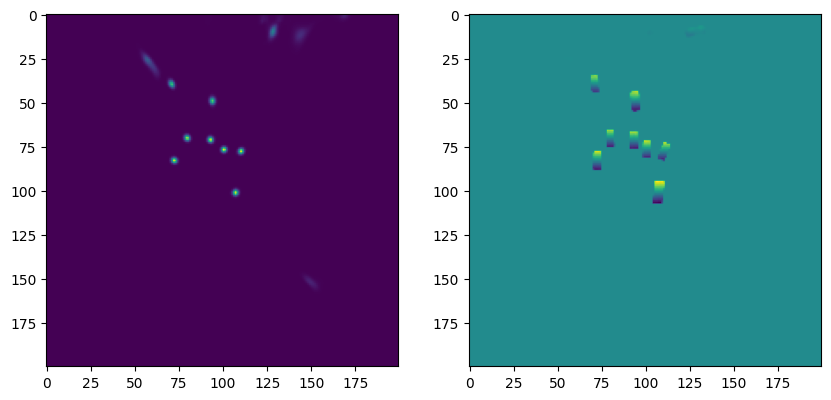

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(pred['center'][0,0].sigmoid().cpu().numpy())
ax2.imshow(pred['offset'][0,1].cpu().numpy())

Text(0.5, 1.0, 'GT & Prediction overlay')

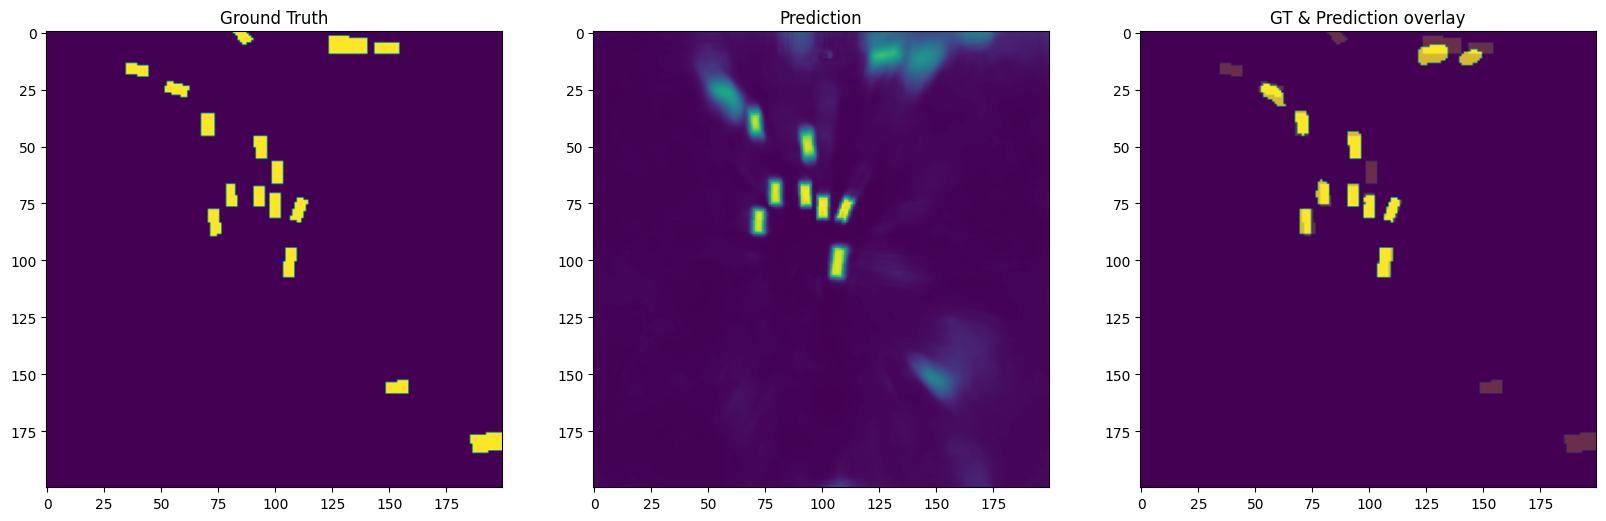

In [ ]:
batch_index = 0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 16))
bev_y = 76
bev_x = 107
vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
# vehicles[:, 0, ::4, ::4] = 1
ax1.imshow(vehicles[batch_index,0].detach().cpu().numpy())
ax1.scatter([102],[100], s=2, c='b')

ax1.set_title('Ground Truth')
# ax1.axis('off')

pred_bev = pred['VEHICLE'][batch_index,0].sigmoid().detach().cpu()
if 'mask' in pred:
    pred_bev = pred_bev * pred['mask'][batch_index,0].cpu()
ax2.imshow((pred_bev).numpy())
# ax2.scatter([bev_x],[bev_y], s=3, c='r')
# ax2.scatter([pred_y*(-2)+100],[pred_x*(-2)+100], s=3, c='g')
ax2.set_title('Prediction')
# plt.title('2D')
# ax2.axis('off')
ax3.imshow(pred_bev>=0.45)
ax3.imshow(vehicles[batch_index,0].detach().cpu().numpy(), alpha=0.2)
ax3.set_title('GT & Prediction overlay')

In [ ]:
stage = 2
h = w = 200
points = rearrange(pred['mid_output'][0]['sample_points_cam'], 'b (h w) p d -> b h w p d',h=h, w=w)
reference_points = rearrange(pred['mid_output'][0]['reference_points'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
weight = rearrange(pred['mid_output'][stage], 'b 1 p h w-> b h w p')

KeyError: 0

: 

In [ ]:
y = bev_y
x = bev_x
bev_prediction_index = pred['VEHICLE'][batch_index,0,y,x].sigmoid()
    
pts_2d = points[batch_index, y, x]
reference_points_index = reference_points[batch_index, y, x]
mask = (pts_2d[:,0] > 0) & (pts_2d[:,0] < 1) & (pts_2d[:,1] > 0) & (pts_2d[:,1] < 1)
pts_2d = pts_2d[mask].cpu().numpy()
reference_points_index = reference_points_index[mask].cpu().numpy()
weight_index = weight[batch_index, y, x]
weight_index = weight_index[mask].cpu().numpy()

pts_2d[:, 0] *= 480
pts_2d[:, 1] *= 224

In [ ]:
cam_index = 3
print("BEV Prediction", bev_prediction_index)
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
for i in range(len(pts_2d)):
    print(f"Reference points:{reference_points_index[i]}\tweight: {np.round(weight_index[i], 4)}")
    # print(f"Sampled points: {np.round(reference_points_index[i], 4)}")
    # print(att_[head_index,i])
    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=6, c='g', alpha=max(0.1, np.round(weight_index[i], 4)))
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], s=2, c='r')
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], alpha=max(float(att_[head_index,i]), 0.1), s=4, c='r')
plt.axis('off')

In [ ]:
stage = 1
h = w = 50 if stage == 0 else 200
points = rearrange(pred['mid_output'][f"stage_{stage}"]['sample_points_cam'], 'b (h w) p d -> b h w p d',h=h, w=w)
pos_3d = rearrange(pred['mid_output'][f"stage_{stage}"]['pos_3d'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
reference_points = rearrange(pred['mid_output'][f"stage_{stage}"]['reference_points'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
weight = rearrange(pred['mid_output'][f"stage_{stage}"]['weight'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
uncertainty = rearrange(pred['mid_output'][f"stage_{stage}"]['uncertainty'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)

In [ ]:
if stage == 0:
    y = bev_y // 4
    x = bev_x // 4
else:
    y = bev_y
    x = bev_x
bev_prediction_index = pred['VEHICLE'][batch_index,0,y,x].sigmoid()
    
pts_2d = points[batch_index, y, x]
reference_points_index = reference_points[batch_index, y, x]
mask = (pts_2d[:,0] > 0) & (pts_2d[:,0] < 1) & (pts_2d[:,1] > 0) & (pts_2d[:,1] < 1)
pts_2d = pts_2d[mask].cpu().numpy()
reference_points_index = reference_points_index[mask].cpu().numpy()
pos_3d_index = pos_3d[batch_index, y, x]
weight_index = weight[batch_index, y, x]
pos_3d_index = pos_3d_index[mask].cpu().numpy()
weight_index = weight_index[mask].cpu().numpy()
uncertainty_index = uncertainty[batch_index, y, x]
uncertainty_index = uncertainty_index[mask].cpu().numpy()

pts_2d[:, 0] *= 480
pts_2d[:, 1] *= 224

In [ ]:
cam_index = 1
print("BEV Prediction", bev_prediction_index)
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
for i in range(len(pts_2d)):
    print(f"Sampled points: {np.round(reference_points_index[i], 4)},\t pos 2d: {np.round(pos_3d_index[i], 4)}, \tweight: {np.round(weight_index[i], 4)}\tuncertainty: {np.round(uncertainty_index[i], 4)}")
    # print(f"Sampled points: {np.round(reference_points_index[i], 4)}")
    # print(att_[head_index,i])
    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=6, c='g', alpha=max(0.1, np.round(weight_index[i], 4)))
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], s=2, c='r')
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], alpha=max(float(att_[head_index,i]), 0.1), s=4, c='r')
plt.axis('off')

In [ ]:
depth = batch['depth'][0]
depth = F.interpolate(depth, scale_factor=0.125, mode='bilinear').cpu()
new_depth = (depth  + pred['depth'].cpu())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(depth[cam_index,0])
ax2.imshow(new_depth[cam_index,0])

In [ ]:
# attention = pred['mid_output']['attention']
# attention = rearrange(attention, '(b h w) m 1 p -> b h w m p', b=4, h=200, w=200)
stage = 3
h = w = 50 # if stage == 0 else 200
points = rearrange(pred['mid_output'][stage]['sample_points_cam'], 'b (h w) p d -> b h w p d',h=h, w=w)
reference_points = rearrange(pred['mid_output'][stage]['reference_points'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)

In [ ]:
y = bev_y // 4
x = bev_x // 4
bev_prediction_index = pred['VEHICLE'][batch_index,0,bev_y,bev_x].sigmoid()
    
pts_2d = points[batch_index, y, x]
reference_points_index = reference_points[batch_index, y, x]
mask = (pts_2d[:,0] > 0) & (pts_2d[:,0] < 1) & (pts_2d[:,1] > 0) & (pts_2d[:,1] < 1)
pts_2d = pts_2d[mask].cpu().numpy()
reference_points_index = reference_points_index[mask].cpu().numpy()
# pos_3d_index = pos_3d[batch_index, y, x]
# weight_index = weight[batch_index, y, x]
# pos_3d_index = pos_3d_index[mask].cpu().numpy()
# weight_index = weight_index[mask].cpu().numpy()

pts_2d[:, 0] *= 480
pts_2d[:, 1] *= 224

In [ ]:
cam_index = 2
print("BEV Prediction", bev_prediction_index)
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
for i in range(len(pts_2d)):
    # print(f"Sampled points: {np.round(reference_points_index[i], 4)},\t pos 2d: {np.round(pos_3d_index[i], 4)}, \tweight: {np.round(weight_index[i], 4)}")
    print(f"Sampled points: {np.round(reference_points_index[i], 4)}")
    # print(att_[head_index,i])

    # plt.scatter(pts_2d[i,0], pts_2d[i,1], s=6, c='g', alpha=max(0.0, np.round(weight_index[i], 4)))
    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=2, c='r')
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], alpha=max(float(att_[head_index,i]), 0.1), s=4, c='r')
plt.axis('off')

In [ ]:
print("Real depth", ((y-100)**2 + (x-100)**2)**0.5 / 2)
img_x = 450
img_y = 100
# print(f"Scale: {network.scale}, Shift: {network.shift}")
# depth = (network.depth_adjust(batch['depth'][0,cam_index,0])).detach().cpu() 
depth = batch['depth'][0,cam_index,0].detach().cpu() # batch['depth'][0,cam_index,0] * network.scale + network.shift
# depth = batch['depth'][0,cam_index,0]
plt.imshow(depth)
plt.scatter([img_x], [img_y], c='r', s=5)
print(depth[img_y,img_x], batch['depth'][0,cam_index,0,img_y,img_x].detach().cpu())

In [ ]:
d = depth[img_y,img_x].cpu().numpy()
d = 17
pts = np.array([img_x, img_y]) * d
pts = np.concatenate((pts, np.array([d, 1])))[:,None]
pts = batch['lidar2img'][0, cam_index].inverse().cpu().numpy() @ pts
print(pts[:2])
pts[2] = 1
print((batch['view'][0].cpu().numpy() @ pts[:3])[:2])

In [ ]:
plt_x = np.array([i for i in range(1, 10)]) * 6
plt_y = []
# depth = (network.depth_adjust(batch['depth'][0,:,0])).detach().cpu() # (batch['depth'][0,:,0] * network.scale + network.shift).detach().cpu()
depth = (batch['depth'][0,:,0] * 0.75).detach().cpu()
for xx in plt_x:
    mask = (batch['lidar_depth'][0] != 0).detach().cpu()
    mask = mask & (depth < xx) & (depth > (xx-1))
    gt_depth = batch['lidar_depth'][0][mask].detach().cpu()
    depth_mask = depth[mask]
    print(f"lidar pts number: {mask.sum()}", torch.abs(gt_depth - depth_mask).mean())
    plt_y.append(torch.abs(gt_depth - depth_mask).mean().cpu().numpy())
plt.plot(plt_x, plt_y)
plt.xlabel('distance')
plt.ylabel('mean error')

In [ ]:
depth = (batch['depth'][0,:,0]).detach().cpu()
mask = (batch['lidar_depth'][0] != 0).detach().cpu()
# mask = mask & (depth < xx) & (depth > (xx-1))
gt_depth = batch['lidar_depth'][0][mask].detach().cpu()
depth_mask = depth[mask]
plt_y = []
for scale in [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]:
    print(torch.abs(gt_depth - depth_mask * scale).mean().cpu().numpy())
    plt_y.append(torch.abs(gt_depth - depth_mask * scale).mean().cpu().numpy())
    
plt.plot([1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6], plt_y)
plt.xlabel('distance')
plt.ylabel('mean error')

In [ ]:
depth = batch['depth'][:,:,0].detach().cpu() # (batch['depth'][0,:,0] * network.scale + network.shift).detach().cpu()
mask = (batch['lidar_depth'] != 0)
gt_depth = batch['lidar_depth'][mask].cpu().numpy()
depth = depth[mask].cpu().numpy()
shifts = []
scales = []
scaling = 10
plt_x = np.array([i for i in range(1, 9)]) * scaling
for xx in plt_x:
    mask_2 = (depth <= xx) & (depth > (xx-scaling))
    print(xx, mask_2.sum())
    tmp_depth = depth[mask_2]
    tmp_gt_depth = gt_depth[mask_2]
    A = np.vstack([tmp_depth, np.ones(tmp_depth.shape)]).T
    b = tmp_gt_depth

    # Solve the least squares problem
    scale, shift= np.linalg.lstsq(A, b)[0]

    # Extract shift and scale
    # shift, scale = solution

    print(f"Shift: {shift}, Scale: {scale}")
    shifts.append(shift)
    scales.append(scale)
# depths_rescale = (shift + (scale * depth))

In [ ]:
scaling = 2
plt_x = np.array([i for i in range(1, 30)]) * scaling
plt_y = []
depth = batch['depth'][0,:,0].detach().cpu()
for xx in plt_x:
    mask = (batch['lidar_depth'][0] != 0)
    mask = mask & (depth <= xx) & (depth > (xx-scaling))
    gt_depth = batch['lidar_depth'][0][mask]
    depth_mask = depth[mask]
    index = xx // 10
    depth_mask = depth_mask * scales[index] + shifts[index]
    print(f"lidar pts number: {mask.sum()}", torch.abs(gt_depth - depth_mask).mean())
    plt_y.append(torch.abs(gt_depth - depth_mask).mean().cpu().numpy())
plt.plot(plt_x, plt_y)
plt.xlabel('distance')
plt.ylabel('mean error')

In [ ]:
scaling = 2
plt_x = np.array([i for i in range(1, 30)]) * scaling
plt_y = []
depth = (network.depth_adjust(batch['depth'][0,:,0])).detach().cpu() # (batch['depth'][0,:,0] * network.scale + network.shift).detach().cpu()
for xx in plt_x:
    mask = (batch['lidar'][0] != 0)
    mask = mask & (depth <= xx) & (depth > (xx-scaling))
    gt_depth = batch['lidar'][0][mask]
    depth_mask = depth[mask]
    print(f"lidar pts number: {mask.sum()}", torch.abs(gt_depth - depth_mask).mean())
    plt_y.append(torch.abs(gt_depth - depth_mask).mean().cpu().numpy())
plt.plot(plt_x, plt_y)
plt.xlabel('distance')
plt.ylabel('mean error')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
feat = pred['mid_output']['inter_output'][1][0].permute(1,2,0).view(-1, 128).cpu().numpy()
# feat = pca.fit_transform(feat).reshape(200,200,128)
feat = feat.reshape(200,200,128)
row, column = 4, 4
fig, ax = plt.subplots(row, column, figsize=(10, 10))
for i in range(row):
    for j in range(column):
        ax[i][j].imshow(feat[:,:,16+ i * row + j])

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create a 3D scatter plot
scatter = go.Scatter3d(
    x=depth[0],
    y=depth[1],
    z=depth[2],
    mode='markers',
    marker=dict(
        size=5,
        color=pred['mid_output']['pred_depth'][0,3,2],            # Color by the z-value
        colorscale='Viridis',
        opacity=0.1
    )
)

# Set up the layout
layout = go.Layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0) # Remove margins
)

# Combine the plot and layout
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
pio.show(fig)


In [ ]:
from nuscenes.nuscenes import NuScenes

# Load the nuScenes dataset (mini-split, in this case).
nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=False)

In [ ]:
from nuscenes.utils.data_classes import LidarPointCloud
import os
from pyquaternion import Quaternion

sample_rec = nusc.get('sample', batch['token'])
min_distance = 1.0

sample_data_token = sample_rec['data']['LIDAR_TOP']
current_sd_rec = nusc.get('sample_data', sample_data_token)
# Load up the pointcloud and remove points close to the sensor.
current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))
current_pc.remove_close(min_distance)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
current_cs_rec = nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
current_pc.rotate(Quaternion(current_cs_rec['rotation']).rotation_matrix)
current_pc.translate(np.array(current_cs_rec['translation']))

In [ ]:
lidar_points = batch['lidar']
# lidar_points[2, :] = 1
# lidar_points = batch['view'][0].cpu().numpy() @ lidar_points
plt.scatter(lidar_points[1], lidar_points[0], s=0.25)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

In [ ]:
lidar2img = batch['lidar2img'][0] # N 4 4
lidar2img = lidar2img @ batch['bev_augm'][0].inverse()

lidar_points = torch.from_numpy(lidar_points) # 4 P
lidar_points = torch.cat([lidar_points, torch.ones_like(lidar_points[0:1])], dim=0)
lidar_points = torch.matmul(lidar2img, lidar_points)[:, :3] # N 3 P
depth = lidar_points[:, 2:3]
homo_nonzero = torch.maximum(depth, torch.zeros_like(depth) + 1e-6)
lidar_points = lidar_points[:, 0:2] / homo_nonzero

In [ ]:
valid_mask = ((depth > 1e-6) \
        & (lidar_points[:, 1:2] > 1)
        & (lidar_points[:, 1:2] < 224 - 1)
        & (lidar_points[:, 0:1] > 1)
        & (lidar_points[:, 0:1] < 480 -1)
)
cam_index = 3
plt.imshow(batch['image'][0,cam_index].permute(1,2,0))
lidar_points_camera = lidar_points[cam_index][:, valid_mask[cam_index,0]]
plt.scatter(lidar_points_camera[0], lidar_points_camera[1], s=0.5)
depth_cam = torch.zeros((224,480))
lidar_points_camera = torch.round(lidar_points_camera).int()
depth_cam[lidar_points_camera[1], lidar_points_camera[0]] = depth[cam_index][0, valid_mask[cam_index,0]]

In [ ]:
depth[cam_index][0, valid_mask[cam_index,0]]

In [ ]:
nusc.render_sample(batch['token'])

In [ ]:
import torch
tensor1 = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tensor2 = torch.tensor([[1.1, 2.1, 3.1], [10.0, 10.0, 10.0]])

# 1. Compute the difference between the two tensors
difference = tensor1 - tensor2

# 2. Compute the norm (Euclidean norm) along the last dimension
norm = torch.norm(difference, dim=1)

# 3. Apply a thresholding function
# Here, we use a Gaussian-like function: exp(-alpha * norm^2)
# alpha = 0.075  # You can tune this parameter
# output = torch.exp(-alpha * norm**2)
# print(norm)
# print(output)
offset = 5
x = torch.linspace(-offset, offset, 100, dtype=torch.float32)
alphas = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.0006]
# alphas = np.linspace(0, 0.025, 11)
# alphas = [0.85, 0.72, 0.74, 0.76, 0.78, 0.8, 0.9]
# alphas = [alpha * 8 for alpha in alphas]
for alpha in alphas:
    y = torch.exp(-alpha * x ** 2)

    # positive_mask = (x >= 0).float()
    # negative_mask = (x < 0).float()
    # gauss_positive = torch.exp(-0.1 * (x / alpha) ** 2)
    # gauss_negative = torch.exp(-0.1 * (x / 0.4) ** 2)
    # y = gauss_positive * positive_mask + gauss_negative * negative_mask

    plt.plot(x.numpy(), y.numpy(), label=str(alpha))

# plt.plot(x, [0.1] * 100)
plt.legend()

In [ ]:
def parse_pose(record, *args, **kwargs):
    return get_pose(record['rotation'], record['translation'], *args, **kwargs)

def get_transformation_matrix(R, t, inv=False):
    pose = np.eye(4, dtype=np.float32)
    pose[:3, :3] = R if not inv else R.T
    pose[:3, -1] = t if not inv else R.T @ -t

    return pose


def get_pose(rotation, translation, inv=False, flat=False):
    if flat:
        yaw = Quaternion(rotation).yaw_pitch_roll[0]
        R = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).rotation_matrix
    else:
        R = Quaternion(rotation).rotation_matrix

    t = np.array(translation, dtype=np.float32)

    return get_transformation_matrix(R, t, inv=inv)

current_sd_rec = nusc.get('sample_data', sample_data_token)
egolidar = nusc.get('ego_pose', current_sd_rec['ego_pose_token'])
print(parse_pose(egolidar), '\n',parse_pose(egolidar,flat=True))

In [ ]:
import torch
max_depth = 60
min_depth = 1
depth_num = 16
depth = torch.zeros((4, 1, 20, 20))
b, _, h, w = depth.shape
depth_range = max_depth - min_depth
interval = depth_range / depth_num
interval = interval * torch.ones_like(depth)
interval = interval.repeat(1, depth_num, 1, 1)
interval = torch.cat([torch.ones_like(depth) * min_depth, interval], 1)

bin_edges = torch.cumsum(interval, 1)
print(bin_edges.shape)
current_depths = 0.5 * (bin_edges[:, :-1] + bin_edges[:, 1:])

In [ ]:
current_depths[0,:,0,0]

In [ ]:
batch = dataset.__getitem__(4000)

In [ ]:
def get_pixel_coords_3d(lidar2img):
    eps = 1e-5
    device = lidar2img.device
    # B, N, C, H, W = depth.shape
    B, N = lidar2img.shape[:2]
    H, W = 28, 60
    scale = 224 // H
    # coords_h = torch.arange(H, device=depth.device).float() * 224 / H
    # coords_w = torch.arange(W, device=depth.device).float() * 480 / W
    coords_h = torch.linspace(scale // 2, 224 - scale//2, H, device=device).float()
    coords_w = torch.linspace(scale // 2, 480 - scale//2, W, device=device).float()

    # if self.LID:
    #     index  = torch.arange(start=0, end=self.depth_num, step=1, device=device).float()
    #     index_1 = index + 1
    #     bin_size = (self.pc_range[3] - self.depth_start) / (self.depth_num * (1 + self.depth_num))
    #     coords_d = self.depth_start + bin_size * index * index_1
    # else:
    index  = torch.arange(start=0, end=64, step=1, device=device).float()
    bin_size = (61 - 1) / 64
    coords_d = 1 + bin_size * index

    D = coords_d.shape[0]
    coords = torch.stack(torch.meshgrid([coords_w, coords_h, coords_d])).permute(1, 2, 3, 0) # W, H, D, 3
    coords = torch.cat((coords, torch.ones_like(coords[..., :1])), -1)
    coords[..., :2] = coords[..., :2] * torch.maximum(coords[..., 2:3], torch.ones_like(coords[..., 2:3])*eps)
    img2lidars = lidar2img.inverse() # b n 4 4

    coords = coords.view(1, 1, W, H, D, 4, 1).repeat(B, N, 1, 1, 1, 1, 1)
    img2lidars = img2lidars.view(B, N, 1, 1, 1, 4, 4).repeat(1, 1, W, H, D, 1, 1)
    coords3d = torch.matmul(img2lidars, coords).squeeze(-1)[..., :3] # B N W H D 3
    coords3d = rearrange(coords3d, 'b n w h d j -> b n h w d j')

    return coords3d, coords_d

def get_coords_3d(depth, lidar2img):
    eps = 1e-5
    img2lidars = lidar2img.inverse() # b n 4 4
    B, N = lidar2img.shape[:2]
    I, _, C, H, W = depth.shape
    depth = rearrange(depth, 'i (b n) c h w -> i b n w h c', b=B, n=N)
    scale = 224 // H

    coords_h = torch.linspace(scale // 2, 224 - scale//2, H, device=depth.device).float()
    coords_w = torch.linspace(scale // 2, 480 - scale//2, W, device=depth.device).float()

    coords_wh = torch.stack(torch.meshgrid([coords_w, coords_h])).permute(1, 2, 0) # W, H, 2
    coords_wh = repeat(coords_wh, '... -> i b n ...', i=I, b=B, n=N)
    coords_whdhomo = torch.cat((coords_wh * depth, depth, torch.ones_like(depth)), dim=-1)[..., None] # i b n w h 4 1
    coords_whdhomo_right = torch.cat((coords_wh * (depth+1), depth+1, torch.ones_like(depth)), dim=-1)[..., None] # i b n w h 4 1

    img2lidars = repeat(img2lidars, 'b n j k -> i b n w h j k', i=I, w=W, h=H) # i b n w h 4 4
    coords3d = torch.matmul(img2lidars, coords_whdhomo).squeeze(-1)[..., :3] # i b n w h 3
    coords3d = rearrange(coords3d, 'i b n w h d -> i b n h w d')

    coords3d_right = torch.matmul(img2lidars, coords_whdhomo_right).squeeze(-1)[..., :3] # i b n w h 3
    coords3d_right = rearrange(coords3d_right, 'i b n w h d -> i b n h w d')
    direction_vector = F.normalize((coords3d_right - coords3d), dim=-1)

    return coords3d[0], direction_vector[0]

coords_3d, depth_d = get_pixel_coords_3d(batch['lidar2img'][None])
direction_vector = F.normalize((coords_3d[..., 1, :] - coords_3d[..., 0, :]), dim=-1)

In [ ]:
def project(points, lidar2img, pre_mask=None):
    points = torch.cat((points, torch.ones_like(points[..., 0:1])), dim=-1) # h w 4
    points = (lidar2img.view(1, 1, 4, 4) @ points.unsqueeze(-1)).squeeze(-1) # h w 4
    points = points.flatten(0,1) # (h w) 4
    mask1 = points[:, 2] > 1e-5
    points[..., 2:3] = torch.maximum(points[..., 2:3], torch.zeros_like(points[..., 2:3]) + 1e-5)
    points[..., :2] /= points[..., 2:3]
    if pre_mask is not None:
        points = points[pre_mask][:,:2]
        mask = None
    else:
        mask2 = (points[:,0] < 480-1) & (points[:,0] >= 0) & (points[:,1] < 224-1) & (points[:,1] >= 0)
        mask = mask1 & mask2
        points = points[mask][:, :2]
    return points, mask

In [ ]:
cam_index = 1
target_cam_index = 2
depth_index = 20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

points, mask = project(coords_3d[0, cam_index,:,:,depth_index], batch['lidar2img'][target_cam_index])
ax2.imshow(batch['image'][target_cam_index].cpu().permute(1,2,0))
ax2.scatter(points[:,0].cpu(), points[:,1].cpu(),s=1.0)

points, _ = project(coords_3d[0, cam_index,:,:,depth_index], batch['lidar2img'][cam_index], mask)
ax1.imshow(batch['image'][cam_index].cpu().permute(1,2,0))
ax1.scatter(points[:,0].cpu(), points[:,1].cpu(),s=1.0)

plt.show()

In [ ]:
points, _ = project(coords_3d[0, cam_index,:,:,depth_index], batch['lidar2img'][cam_index], mask)

plt.imshow(batch['image'][cam_index].cpu().permute(1,2,0))
plt.scatter(points[:,0].cpu(), points[:,1].cpu(),s=1.0)

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create a 3D scatter plot
# W_idx = 30
# H_idx = 14
# scatter_1 = go.Scatter3d(
#     x=pred['mid_output']['mean'][0,:,0].cpu().numpy(),
#     y=pred['mid_output']['mean'][0,:,1].cpu().numpy(),
#     z=pred['mid_output']['mean'][0,:,2].cpu().numpy(),
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=pred['mid_output']['mean'][0,:,2].cpu().numpy(),            # Color by the z-value
#         colorscale='Viridis',
#         opacity=0.5
#     )
# )
W_idx = 25
H_idx = 14
scatter_2 = go.Scatter3d(
    x=coords_3d[0, 1, W_idx, H_idx, :, 0],
    y=coords_3d[0, 1, W_idx, H_idx, :, 1],
    z=coords_3d[0, 1, W_idx, H_idx, :, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=coords_3d[0, 1, W_idx, H_idx, :, 2],            # Color by the z-value
        colorscale='Viridis',
        opacity=0.5
    )
)

# Set up the layout
layout = go.Layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0) # Remove margins
)

# Combine the plot and layout
fig = go.Figure(data=[scatter_2], layout=layout)

# Show the plot
pio.show(fig)


In [ ]:
import torch
H = 28
W = 60
scale=8
coords_h = torch.linspace(scale // 2, 224 - scale//2, H).float()
coords_w = torch.linspace(scale // 2, 480 - scale//2, W).float()

coords = torch.stack(torch.meshgrid([coords_w, coords_h])).permute(1, 2, 0)
print(coords.shape)

In [ ]:
import numpy as np
import plotly.graph_objs as go
from scipy.stats import multivariate_normal

# Parameters for the 3D multivariate normal distribution
# tensor([[[ 4.2791, -1.4778, -0.3377,  0.5105,  0.1166,  0.0268]]],
#        device='cuda:0')
# mean: tensor([[11.6172, -3.5230,  0.7330]], device='cuda:0')
mean = [11.6172, -3.5230,  0.7330]  # Mean of the distribution
cov = [[4.2791, -1.4778, -0.3377], [-1.4778, 0.5105,  0.1166], [-0.3377, 0.1166, 0.0268]]  # Covariance matrix
print(cov)
# Generate a grid of points in 3D space
x, y, z = np.mgrid[
    mean[0]-4*cov[0][0]:mean[0]+4*cov[0][0]:30j, 
    mean[1]-4*cov[1][1]:mean[1]+4*cov[1][1]:30j, 
    mean[2]-4*cov[2][2]:mean[2]+4*cov[2][2]:30j]
pos = np.empty(x.shape + (3,))
pos[:, :, :, 0] = x
pos[:, :, :, 1] = y
pos[:, :, :, 2] = z

# Create the multivariate normal distribution
rv = multivariate_normal(mean, cov)

# Compute the probability density function (PDF) over the grid
pdf_values = rv.pdf(pos)

# Create the 3D surface plot using plotly
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=pdf_values.flatten(),
    isomin=pdf_values.min(),
    isomax=pdf_values.max(),
    opacity=0.1,  # Adjust transparency
    surface_count=15,  # Number of isosurfaces
    colorscale='Viridis'
))

# Update layout for the 3D plot
fig.update_layout(
    title='3D Multivariate Normal Distribution',
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    )
)

# Show the plot
fig.show()


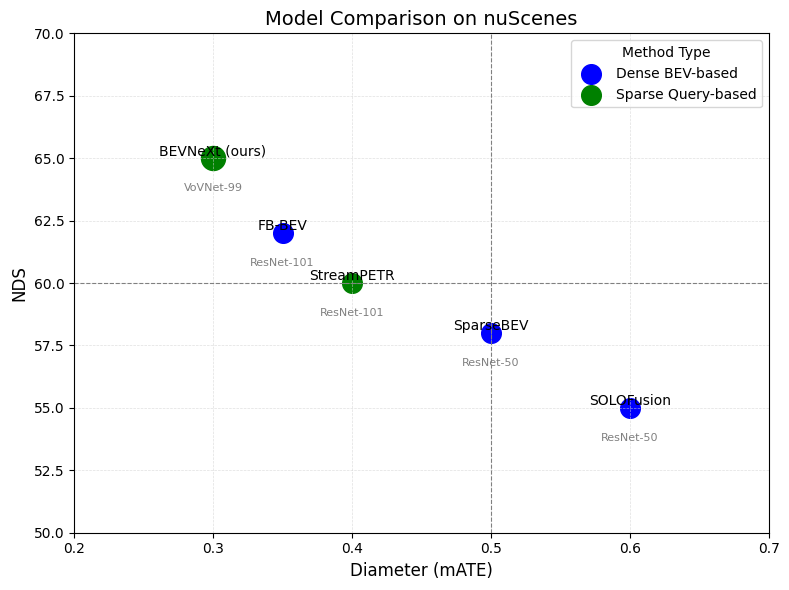

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['SOLOFusion', 'StreamPETR', 'SparseBEV', 'FB-BEV', 'BEVNeXt (ours)']
categories = ['Dense BEV-based', 'Sparse Query-based', 'Dense BEV-based', 'Dense BEV-based', 'Sparse Query-based']
nds = [55, 60, 58, 62, 65]  # NDS scores
mATE = [0.6, 0.4, 0.5, 0.35, 0.3]  # Diameter (mATE)
backbones = ['ResNet-50', 'ResNet-101', 'ResNet-50', 'ResNet-101', 'VoVNet-99']  # Annotations

# Grouping for color
colors = {'Dense BEV-based': 'blue', 'Sparse Query-based': 'green'}
sizes = [200, 200, 200, 200, 300]  # Size of the circles

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for i, model in enumerate(models):
    ax.scatter(mATE[i], nds[i], color=colors[categories[i]], s=sizes[i], label=categories[i] if categories[i] not in ax.get_legend_handles_labels()[1] else "")
    ax.text(mATE[i], nds[i], model, fontsize=10, ha='center', va='bottom')
    ax.text(mATE[i], nds[i] - 1, backbones[i], fontsize=8, ha='center', va='top', color='gray')

# Add axis lines and grid
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.8)  # Vertical split
ax.axhline(y=60, color='gray', linestyle='--', linewidth=0.8)  # Horizontal guide
ax.grid(color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend and labels
ax.legend(loc='upper right', fontsize=10, title='Method Type')
ax.set_xlabel('Diameter (mATE)', fontsize=12)
ax.set_ylabel('NDS', fontsize=12)
ax.set_title('Model Comparison on nuScenes', fontsize=14)

# Adjust axis limits
ax.set_xlim(0.2, 0.7)
ax.set_ylim(50, 70)

# Show plot
plt.tight_layout()
plt.show()
